# 核心模块 Core Module

> 主要定义与任务相关的核心组件和配置
> 
> Defines core components and configurations related to tasks

## 简介/Description: 

核心模块包含任务相关的主要类和配置文件，如 ClassificationTask 和 ClassificationTaskConfig。其中配置文件通过 Pydantic 进行定义，帮助用户更好地构建图像分类任务的各个部分。

The core module contains the primary classes and configuration files related to tasks, such as ClassificationTask and ClassificationTaskConfig, where the configurations are defined using Pydantic, allowing users to easily structure components of image classification tasks.

## 主要符号/Main symbols:

- ClassificationTask: 用于处理图像分类任务的 PyTorch Lightning 模块。
- ClassificationTask: A PyTorch Lightning module for handling image classification tasks.
- ClassificationTaskConfig: 使用 Pydantic 设计的配置类，用于初始化任务。
- ClassificationTaskConfig: A configuration class designed with Pydantic for initializing the task.


In [1]:
#| default_exp core

In [2]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [3]:
#| export
import os
os.environ['HF_ENDPOINT'] = "https://hf-mirror.com" # TODO this is optional for Foreigners

In [4]:
#| export
from pydantic import BaseModel
class ClassificationModelConfig(BaseModel):
    provider: str = "huggingface"
    checkpoint: str = "google/vit-base-patch16-224-in21k" # TODO 支持 hf  timm torch
    head_strategy: str = "linear"
    num_of_classes: int = -1
    
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import AutoModel, AutoConfig, ViTModel, ViTConfig
from transformers import AutoImageProcessor, BitImageProcessor, ViTImageProcessor

class HuggingfaceModel(nn.Module):
    """Some Information about HuggingfaceModel"""
    def __init__(self, config : ClassificationModelConfig, forward_with_hf_image_preprocessor=False):
        super().__init__()
        # self.image_preprocessor = BitImageProcessor.from_pretrained(config.model_checkpoint, use_fast=True)
        self.image_preprocessor = AutoImageProcessor.from_pretrained(config.checkpoint)
        self.backbone: ViTModel = AutoModel.from_pretrained(config.checkpoint) # TODO we now just consider ViTModel
        self.backbone_config: ViTConfig = self.backbone.config # 包括了 image_size 和 hidden_size 这两个重要信息
        if config.head_strategy == "linear":
            self.head = nn.Linear(self.backbone_config.hidden_size, config.num_of_classes)
        else:
            raise NotImplementedError("Only linear head is supported for now. ")
        self.config = config
        self.forward_with_hf_image_preprocessor = forward_with_hf_image_preprocessor
    
    
    
    def forward(self, x:torch.Tensor)->torch.Tensor:
        if self.forward_with_hf_image_preprocessor:
            x = self.image_preprocessor(images=x, return_tensors="pt")["pixel_values"]
        hf_output = self.backbone(x)
        # hidden_state = hf_output.last_hidden_state
        output = hf_output.pooler_output
        output = self.head(output)
        return output
    
from fastcore.basics import patch
@patch
def get_cls_model(self:ClassificationModelConfig):
    if self.provider == "huggingface":
        return HuggingfaceModel(self)
    else:
        raise NotImplementedError("Only huggingface is supported for now. ")

In [5]:
#| export
import lightning as L
from pydantic import BaseModel
from namable_classify.data import ClassificationDataConfig, ClassificationDataModule

class ClassificationTaskConfig(BaseModel):
    experiment_index: int = 0  # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 表示是第几次重复实验 # which is also the random seed
    label_smoothing: float = 0.1
    cls_model_config: ClassificationModelConfig = ClassificationModelConfig()
    dataset_config: ClassificationDataConfig = ClassificationDataConfig()
    learning_rate: float = 3e-4

In [8]:
#| export
import lightning as L
from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS, STEP_OUTPUT, OptimizerLRScheduler
from overrides import override
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from namable_classify.utils import print_model_pretty
class ClassificationTask(L.LightningModule):
    def __init__(self, config: ClassificationTaskConfig)->None:
        super().__init__()
        self.save_hyperparameters(config.model_dump())
        L.seed_everything(config.experiment_index) # use index as the seed for reproducibility
        # 首先数据是可以加载的
        self.lit_data:ClassificationDataModule = config.dataset_config.get_lightning_data_module()
        # 数据怎么做Transform，取决于 Model的情况
        # 现在我们加载Model，刚才有了数据之后，首先可以更新 cls_model_config
        
        config.cls_model_config.num_of_classes = self.lit_data.num_of_classes
        self.cls_model:HuggingfaceModel = config.cls_model_config.get_cls_model()
        
        # 现在需要更新数据
        self.lit_data.set_transform_from_hf_image_preprocessor(hf_image_preprocessor=self.cls_model.image_preprocessor)
        
        
        # 最后是训练策略
        self.loss = nn.CrossEntropyLoss(label_smoothing=config.label_smoothing)
        self.softmax = nn.Softmax(dim=1)    
        # nn.LogSoftmax(dim=1)
        # https://blog.csdn.net/qq_43391414/article/details/118421352 logsoftmax+nll的速度快，但是没有label smoothing
        
        # 评价策略
        self.evaluation_steps_outputs = dict()
    
    def compute_model_logits(self, image_tensor:torch.Tensor)-> torch.Tensor:
        return self.cls_model(image_tensor)
    
    @override
    def forward(self, image_tensor:torch.Tensor, *args, **kwargs)-> torch.Tensor:
        return self.softmax(self.compute_model_logits(image_tensor))

    def forward_loss(self, image_tensor: torch.Tensor, label_tensor:torch.Tensor)->torch.Tensor:
        probs = self(image_tensor)
        # return F.nll_loss(logits, label_tensor)
        return self.loss(probs, label_tensor)
    
    @override
    def training_step(self, batch, batch_idx=None, *args, **kwargs)-> STEP_OUTPUT:
        loss = self.forward_loss(*batch)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    @override    
    def configure_optimizers(self) -> OptimizerLRScheduler:
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)
        # return L.AdamW(self.parameters(), lr=self.learning_rate)

    # @override
    # def 

## 现在我们已经定义好Training的逻辑了，已经可以跑训练了。

In [7]:
config = ClassificationTaskConfig()
config
cls_task = ClassificationTask(config)
cls_task.print_model_pretty()

Seed set to 0
/home/ycm/program_files/managers/conda/envs/hf_ai/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


KeyboardInterrupt: 

In [42]:
trainer = L.Trainer()
from lightning.pytorch.tuner import Tuner
tuner = Tuner(trainer)
found_batch_size = tuner.scale_batch_size(cls_task, datamodule=cls_task.lit_data)
found_batch_size

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ycm/program_files/managers/conda/envs/hf_ai/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
/home/ycm/program_files/managers/conda/envs/hf_ai/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


Files already downloaded and verified
Files already downloaded and verified


Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/ycm/program_files/managers/conda/envs/hf_ai/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 2 succeeded, trying batch size 4
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 4 succeeded, trying batch size 8
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 8 succeeded, trying batch size 16
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 16 succeeded, trying batch size 32
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 32 succeeded, trying batch size 64
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 64 succeeded, trying batch size 128
Batch size 128 failed, trying batch size 

64

In [45]:
cls_task.lit_data.hparams.batch_size

64

/home/ycm/program_files/managers/conda/envs/hf_ai/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


Files already downloaded and verified
Files already downloaded and verified


Seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/ycm/program_files/managers/conda/envs/hf_ai/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0630957344480193
Restoring states from the checkpoint path at /home/ycm/repos/research/cv/cls/NamableClassify/nbs/.lr_find_b4c83835-e249-4510-99f9-6ffc37f9403c.ckpt
Restored all states from the checkpoint at /home/ycm/repos/research/cv/cls/NamableClassify/nbs/.lr_find_b4c83835-e249-4510-99f9-6ffc37f9403c.ckpt


{'lr': [1e-08, 1.4454397707459274e-08, 1.7378008287493753e-08, 2.0892961308540398e-08, 2.51188643150958e-08, 3.019951720402016e-08, 3.630780547701014e-08, 4.36515832240166e-08, 5.248074602497726e-08, 6.309573444801934e-08, 7.585775750291837e-08, 9.120108393559096e-08, 1.0964781961431852e-07, 1.3182567385564074e-07, 1.5848931924611133e-07, 1.9054607179632475e-07, 2.2908676527677735e-07, 2.7542287033381663e-07, 3.311311214825911e-07, 3.9810717055349735e-07, 4.786300923226383e-07, 5.75439937337157e-07, 6.918309709189366e-07, 8.317637711026709e-07, 1e-06, 1.2022644346174132e-06, 1.445439770745928e-06, 1.7378008287493761e-06, 2.089296130854039e-06, 2.5118864315095797e-06, 3.0199517204020163e-06, 3.630780547701014e-06, 4.365158322401661e-06, 5.248074602497728e-06, 6.3095734448019305e-06, 7.585775750291836e-06, 9.120108393559096e-06, 1.0964781961431852e-05, 1.3182567385564076e-05, 1.584893192461114e-05, 1.9054607179632464e-05, 2.2908676527677725e-05, 2.7542287033381663e-05, 3.311311214825911e

(0.0630957344480193, 0.0630957344480193)

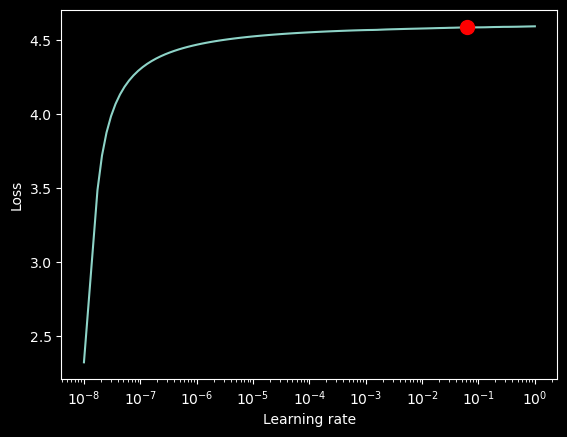

In [47]:
lr_finder = tuner.lr_find(cls_task, datamodule=cls_task.lit_data)
print(lr_finder.results)
fig = lr_finder.plot(suggest=True)
fig.show()
new_lr = lr_finder.suggestion()
new_lr, cls_task.hparams.learning_rate

## 然而，除了训练之外，我们需要评测模型的性能。


In [10]:
from namable_classify.utils import partial_with_self, append_dict_list, compute_classification_metrics, ensure_array, logger
import numpy as np

In [11]:
from typing import Any


@patch
def on_evaluation_start(self:ClassificationTask, stage:str=""):
    self.evaluation_steps_outputs = dict()
    self.evaluation_steps_outputs[f'{stage}_batch_probs'] = []
    self.evaluation_steps_outputs[f'{stage}_label_tensor'] = []
        
@patch
def evaluation_step(self:ClassificationTask, batch, batch_idx=None, stage:str="", *args: Any, **kwargs: Any) -> STEP_OUTPUT:
    image_tensor, label_tensor = batch
    batch_probs = self.model_softmax(image_tensor)
    append_dict_list(self.evaluation_steps_outputs, f'{stage}_batch_probs', ensure_array(batch_probs))
    append_dict_list(self.evaluation_steps_outputs, f'{stage}_label_tensor', ensure_array(label_tensor))
    batch_loss = self.loss(batch_probs, label_tensor)
    self.log(f"{stage}_loss", batch_loss, prog_bar=True)
    return batch_loss
        
@patch    
def on_evaluation_epoch_end(self:ClassificationTask, stage:str=""):
    # https://github.com/Lightning-AI/pytorch-lightning/discussions/9845
    labels = self.train_dataset.dataset.classes
    # print(labels)
    # stack 是 new axis， concat是existing axis
    all_pred_probs = np.concatenate(self.evaluation_steps_outputs[f'{stage}_batch_probs'])
    all_label_tensor = np.concatenate(self.evaluation_steps_outputs[f'{stage}_label_tensor'])
    logger.debug(self.evaluation_steps_outputs[f'{stage}_label_tensor'])
    logger.debug(all_label_tensor)
    eval_dict = compute_classification_metrics(all_label_tensor, all_pred_probs, logits_to_prob=False, 
                                               labels=labels)
    eval_dict = {f"{stage}_{k}": v for k,v in eval_dict.items()}
    self.log_dict(eval_dict)
    self.evaluation_steps_outputs.clear()

@patch    
def on_validation_epoch_start(self:ClassificationTask):
    return self.on_evaluation_epoch_start(stage="val")

@patch    
def on_test_epoch_start(self:ClassificationTask):
    return self.on_evaluation_epoch_start(stage="test")

@patch    
def on_validation_epoch_end(self:ClassificationTask):
    return self.on_evaluation_epoch_end(stage="val")

@patch    
def on_test_epoch_end(self:ClassificationTask):
    return self.on_evaluation_epoch_end(stage="test")

@patch
def validation_step(self:ClassificationTask, batch, batch_idx=None):
    return self.evaluation_step(batch, batch_idx, stage="val")

@patch
def test_step(self:ClassificationTask, batch, batch_idx=None):
    return self.evaluation_step(batch, batch_idx, stage="test")


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()